<h1> The Open Power System Data (OPSD) Data Set  </h1>

In [1]:
from pathlib import Path
import sys
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg
from src import eda_utils
from src import plotting_utils
from src import config as cfg
from src import filter_group_aggr_utils as fga

from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import math


<h2> Download the Hourly Time Series </h2>

The open data platform [OPSD](https://open-power-system-data.org/) provides time series at different temporal resolutions. The following cell downloads the hourly time series.

In [2]:
OPSD_60min_df = None
URL = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

if cfg.OPSD_60min_CSV.exists():
    OPSD_60min_df = pd.read_csv(cfg.OPSD_60min_CSV)
    print("(Re-)loaded hourly OPSD dataset into OPSD_60min_df.")
else:
    print('Not found: "OPSD_time_series_60min_singleindex.csv" in data/raw/.')
    print("Attempting to download from:", URL)
    try:
        from urllib.request import urlopen
        with urlopen(URL) as r, open(cfg.OPSD_60min_CSV, "wb") as f:
            f.write(r.read())
        OPSD_60min_df = pd.read_csv(cfg.OPSD_60min_CSV)
        print("Successfully downloaded and loaded the hourly OPSD dataset into OPSD_60min_df.")
    except Exception as e:
        print("Unfortunately, the download failed.")
        print("Reason:", repr(e))
        print("Please, try to download it manually, and place it at:", cfg.OPSD_60min_CSV)


(Re-)loaded hourly OPSD dataset into OPSD_60min_df.


The `.info()` and `.shape` output: 

In [3]:
print("   .info():") 
print(OPSD_60min_df.info())
print("   .shape:")
print(OPSD_60min_df.shape)

   .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB
None
   .shape:
(50401, 300)


The first and last rows:

In [4]:
display(OPSD_60min_df.head(3))
display(OPSD_60min_df.tail(3))

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
50398,2020-09-30T21:00:00Z,2020-09-30T23:00:00+0200,5932.0,5813.0,NaN,NaN,1771.0,8763.0,8873.0,NaN,...,1250.17,1274.0,5.58,0.66,2940.0,2890.0,1.6,1.0,NaN,NaN
50399,2020-09-30T22:00:00Z,2020-10-01T00:00:00+0200,5628.0,5424.0,NaN,NaN,1779.0,8131.0,8285.0,NaN,...,1206.82,1178.0,5.61,0.21,2823.0,2740.0,1.7,1.2,NaN,NaN
50400,2020-09-30T23:00:00Z,2020-10-01T01:00:00+0200,5395.0,5204.0,NaN,NaN,1661.0,7837.0,7943.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(OPSD_60min_df[["cet_cest_timestamp", "utc_timestamp"]].head(3))
print(OPSD_60min_df[["cet_cest_timestamp", "utc_timestamp"]].tail(3))

         cet_cest_timestamp         utc_timestamp
0  2015-01-01T00:00:00+0100  2014-12-31T23:00:00Z
1  2015-01-01T01:00:00+0100  2015-01-01T00:00:00Z
2  2015-01-01T02:00:00+0100  2015-01-01T01:00:00Z
             cet_cest_timestamp         utc_timestamp
50398  2020-09-30T23:00:00+0200  2020-09-30T21:00:00Z
50399  2020-10-01T00:00:00+0200  2020-09-30T22:00:00Z
50400  2020-10-01T01:00:00+0200  2020-09-30T23:00:00Z


In summary, a first look at the data set shows: The data ranges from **2015-01-01** to **2020-10-01**. Stepwidth: one hour.  That adds up to $50 401$ rows, with data features comprising $300$ columns.  

From the [**ENTSO-E**](https://eepublicdownloads.entsoe.eu/clean-documents/Publications/Statistics/MS_guidelines2016.pdf) documentation, we learn that:

*"The hourly load value is the average power measured during the preceding hour; for example, the hourly load at 3 a.m. represents the average power measured from 2:00 to 3:00.”* 

We have two  **timestamp** columns, namely `utc_timestamp` and `cet_cest_timestamp`, currently of the `object` data type. We convert to `datetime` but keep the original DataFrame as   `OPSD_60min_original_df`.


In [39]:
OPSD_60min_original_df = OPSD_60min_df.copy()

In [7]:
# Ensure both timestamp columns are parsed correctly
OPSD_60min_df['utc_timestamp'] = pd.to_datetime(OPSD_60min_df['utc_timestamp'], utc=True)
# For 'cet_cest_timestamp', which has mixed CET/CEST (i.e., daylight saving time), parse with timezone awareness
OPSD_60min_df['cet_cest_timestamp'] = pd.to_datetime(OPSD_60min_df['cet_cest_timestamp'], utc=True).dt.tz_convert('Europe/Berlin')

In [8]:
OPSD_60min_df[["cet_cest_timestamp", "utc_timestamp"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   cet_cest_timestamp  50401 non-null  datetime64[ns, Europe/Berlin]
 1   utc_timestamp       50401 non-null  datetime64[ns, UTC]          
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1)
memory usage: 787.6 KB


Now, we have a closer look at the remaining $298$ features.

In [9]:
OPSD_column_names_lst = OPSD_60min_df.columns.tolist()

In [10]:
OPSD_column_names_lst 

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

Generally, the electricity data is organized by country, transmission system operators' (TSO) control areas and bidding zones. Column names start with `DE` when referring to Germany, with `LU` when referring to Luxembourg etc. The common bidding zone Germany-Luxembourg has `DE_LU` as a prefix. Germany has many more columns than any other country. This is due to the territorial subdivision into four different TSO Control Areas. To complicate matters even further, two of them have a control area that consists of two different connected components.  

<h2>Data Completeness Analysis </h2> 

<h3> Column-wise Missingness</h3> 

In [11]:
df = globals().get("OPSD_60min_df")
if df is None:
    print(
        "No DataFrame named OPSD_60min_df found. "
        "Load it first by running the preceding cells, then re-run this cell."
    )
else:
    
    opsd_60min_columnwise_missingness_df = eda_utils.build_columnwise_missingness_report(
        df,
        # sort_index=2,       # 0=column, 1=n_missing, 2=frac_missing
        # descending=True,
        # nan_position="last"
    )

    print(f"Columns analyzed: {len(opsd_60min_columnwise_missingness_df)}")
    print(opsd_60min_columnwise_missingness_df.info())
    print("\nTop 20 by relative missingness:\n")
    display(opsd_60min_columnwise_missingness_df.head(20))

    print("\nBottom 20 by relative missingness:\n")
    display(opsd_60min_columnwise_missingness_df.tail(20))


Columns analyzed: 300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   column        300 non-null    object 
 1   n_missing     300 non-null    int64  
 2   frac_missing  300 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.2+ KB
None

Top 20 by relative missingness:



,column,n_missing,frac_missing
0,HR_solar_generation_actual,50391,0.999802
1,HR_wind_onshore_generation_actual,50379,0.999564
2,PT_wind_generation_actual,47509,0.942620
3,PT_wind_offshore_generation_actual,47509,0.942620
4,PL_solar_generation_actual,46237,0.917383
5,HU_solar_generation_actual,41436,0.822127
6,SK_wind_onshore_generation_actual,40722,0.807960
7,NO_5_wind_onshore_generation_actual,40132,0.796254
8,NO_1_wind_onshore_generation_actual,35815,0.710601
9,DE_LU_load_forecast_entsoe_transparency,33745,0.669530



Bottom 20 by relative missingness:



,column,n_missing,frac_missing
280,DE_50hertz_load_actual_entsoe_transparency,1,0.00002
281,DE_50hertz_load_forecast_entsoe_transparency,1,0.00002
282,DE_50hertz_wind_generation_actual,1,0.00002
283,DE_50hertz_wind_offshore_generation_actual,1,0.00002
284,DE_50hertz_wind_onshore_generation_actual,1,0.00002
285,DE_amprion_load_actual_entsoe_transparency,1,0.00002
286,DE_amprion_load_forecast_entsoe_transparency,1,0.00002
287,DE_amprion_wind_onshore_generation_actual,1,0.00002
288,DE_tennet_load_actual_entsoe_transparency,1,0.00002
289,DE_tennet_load_forecast_entsoe_transparency,1,0.00002


All non-timestamp columns have at least one NaN value. 

<h3> Row-wise Missingness</h3> 

We count the number of NaN values in each row and store the results in a new DataFrame named `missingness_summary_df`.

In [12]:
missingness_summary_df = eda_utils.count_missing_per_row(OPSD_60min_df)
display(missingness_summary_df.head(50))
missingness_summary_df.info()

,utc_timestamp,cet_cest_timestamp,miss_count
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,285
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,225
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,104
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,104
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,104
5,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+01:00,102
6,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+01:00,102
7,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+01:00,101
8,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+01:00,92
9,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+01:00,86


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   utc_timestamp       50401 non-null  datetime64[ns, UTC]          
 1   cet_cest_timestamp  50401 non-null  datetime64[ns, Europe/Berlin]
 2   miss_count          50401 non-null  int64                        
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), int64(1)
memory usage: 1.2 MB


During the first two days, the trend shows a steady, almost monotonic decrease. To investigate further, we plot the missingness results.

<h3>Plot Missingness </h3>

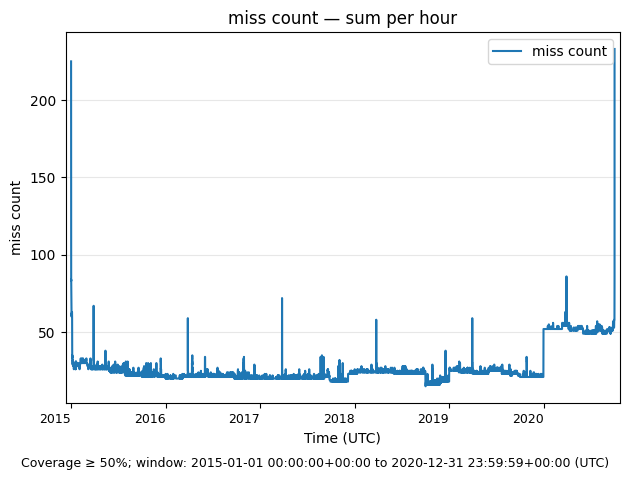

In [13]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2015-01-01 00:00",
          end_date="2020-12-31 23:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

Spikes in missingness can be observed at the beginning and end of the dataset, as well as annually in spring. We begin by taking a closer look at the springtime occurrences.

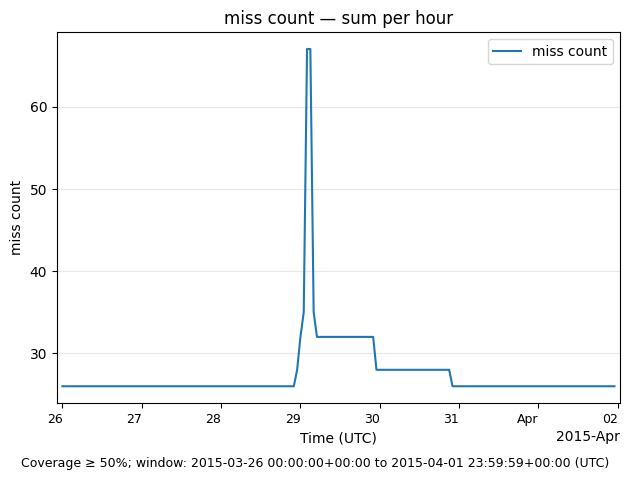

In [14]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2015-03-26 00:00",
          end_date="2015-04-01 23:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

On 29 March 2015, Germany and other European countries switched to Daylight Saving Time, skipping one hour at 02:00 local time. In Germany, this corresponded to `01:00 UTC`, while in other countries it occurred at either `00:00` or `01:00 UTC`, depending on their time zone.    

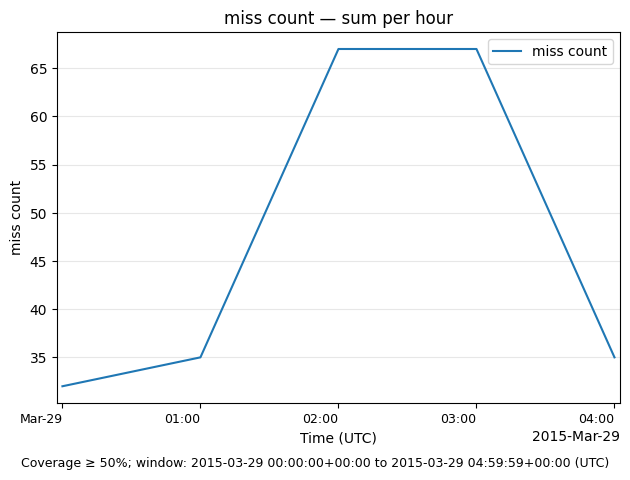

In [15]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2015-03-29 00:00",
          end_date="2015-03-29 04:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

The spike spans two consecutive hours — not `00:00` and `01:00 UTC` as expected, but rather `02:00` and `03:00 UTC`.

These are all the DST jump dates in our data set's time span.   

   `2015-03-29`,   `2016-03-27`,   `2017-03-26`,   `2018-03-25`,   `2019-03-31`,   `2020-03-29`

2016

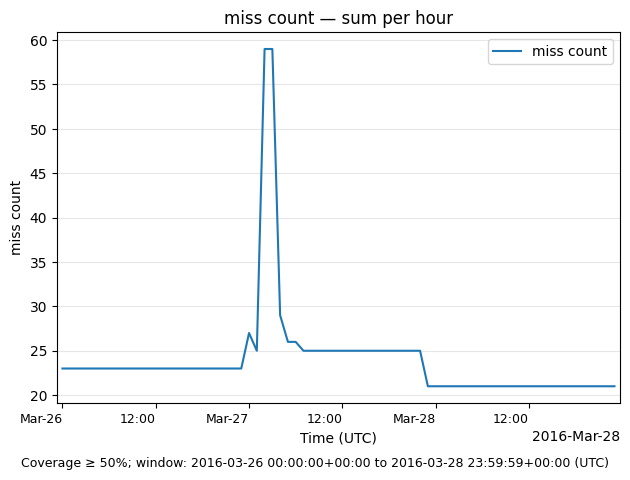

In [16]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2016-03-26 00:00",
          end_date="2016-03-28 23:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

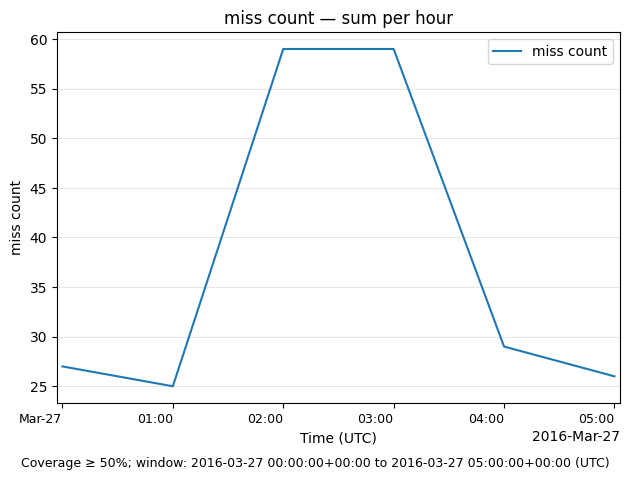

In [17]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2016-03-27 00:00",
          end_date="2016-03-27 05:00:00",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

Again, not `00:00` and `01:00 UTC`, but  `02:00` and `03:00 UTC`.

2017

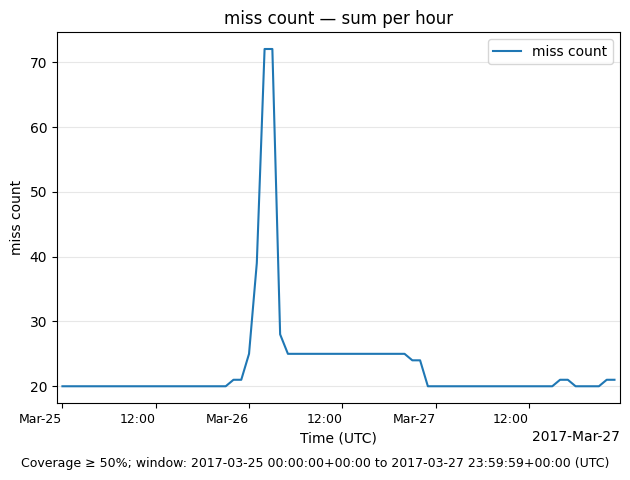

In [18]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2017-03-25 00:00",
          end_date="2017-03-27 23:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

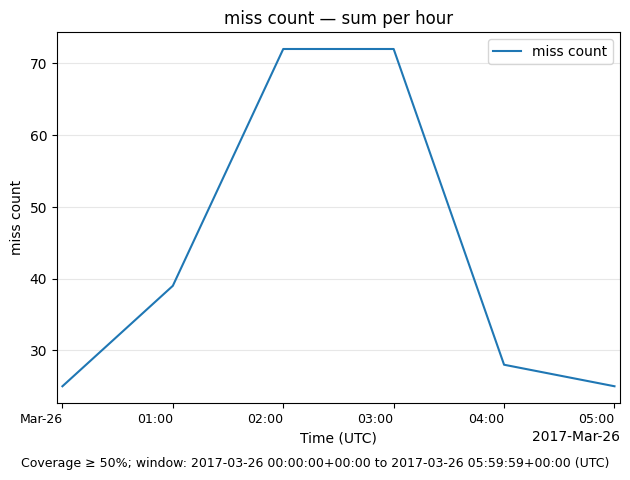

In [19]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_df,
      start_date="2017-03-26 00:00",
          end_date="2017-03-26 05:59:59",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title=None)

At this point, the pattern seems to be clear. Its investigation deserves a section of its own.

<h3> DST Jump Dates </h3>

We investigate the original DataFrame `OPSD_60min_original_df`, to exclude effects of date time conversions.  We abstain from date time conversion in the process as well, and rely on string matching, instead. 

In [20]:
jump_dates = ["2015-03-29", "2016-03-27", "2017-03-26", "2018-03-25", "2019-03-31","2020-03-29",]

In [21]:
# We target an interval of several hours, containing the jump hour.
# Build exact ISO-8601 UTC stamps matching the "YYYY-MM-DDTHH:MM:SSZ" strings in
# OPSD_60min_original_df
targets = []
for d in jump_dates:
    targets.extend([f"{d}T00:00:00Z", f"{d}T01:00:00Z",  f"{d}T02:00:00Z", f"{d}T03:00:00Z", f"{d}T04:00:00Z"
    ])

# Ensure we compare strings without altering datetimes
col = "utc_timestamp"
assert col in OPSD_60min_original_df.columns, "utc_timestamp column not found."
utc_as_str = OPSD_60min_original_df[col].astype(str)  # safe: doesn't change underlying data
# Filter exactly those timestamps
mask = utc_as_str.isin(targets)
dst_jump_rows = OPSD_60min_original_df.loc[mask].copy()
# Optional: sort for readability (lexicographic sort works for ISO-UTC strings)
dst_jump_rows = dst_jump_rows.sort_values(col)
# Quick check
print(f"Found {mask.sum()} rows (expected 5 per year within data range).")
display(dst_jump_rows)

Found 30 rows (expected 5 per year within data range).


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
2089,2015-03-29T00:00:00Z,2015-03-29T01:00:00+0100,5709.0,5495.0,9.0,0.0,211.0,8860.0,8915.0,0.0,...,883.3400,915.4100,0.0000,0.0000,2621.0000,2620.0000,0.0,NaN,NaN,NaN
2090,2015-03-29T01:00:00Z,2015-03-29T03:00:00+0200,5583.0,5302.0,NaN,0.0,163.0,8424.0,8546.0,0.0,...,978.6400,883.3400,0.0000,0.0000,2573.0000,2670.0000,0.0,NaN,NaN,NaN
2091,2015-03-29T02:00:00Z,2015-03-29T04:00:00+0200,5576.0,5354.0,NaN,0.0,163.0,8397.0,8419.0,0.0,...,1016.3567,889.6133,0.0000,0.0000,2592.3333,2666.6667,0.0,NaN,NaN,NaN
2092,2015-03-29T03:00:00Z,2015-03-29T05:00:00+0200,5665.0,5468.0,NaN,0.0,172.0,8389.0,8401.0,0.0,...,1054.0733,895.8867,0.0000,0.0000,2611.6667,2663.3333,0.0,NaN,NaN,NaN
2093,2015-03-29T04:00:00Z,2015-03-29T06:00:00+0200,5716.0,5615.0,13.0,1.0,191.0,8483.0,8384.0,0.0,...,1091.7900,902.1600,0.0000,0.0000,2631.0000,2660.0000,0.0,NaN,NaN,NaN
10825,2016-03-27T00:00:00Z,2016-03-27T01:00:00+0100,5392.0,5467.0,10.0,0.0,244.0,8310.0,8992.0,0.0,...,995.0300,1038.0000,0.0000,0.0000,2578.0000,2630.0000,0.0,NaN,NaN,NaN
10826,2016-03-27T01:00:00Z,2016-03-27T03:00:00+0200,5283.0,5227.0,8.0,0.0,127.0,8079.0,8656.0,0.0,...,934.0900,1019.0000,0.0000,0.0000,2552.0000,2670.0000,0.0,NaN,NaN,NaN
10827,2016-03-27T02:00:00Z,2016-03-27T04:00:00+0200,5245.0,5264.0,NaN,0.0,78.0,8012.0,8563.0,0.0,...,949.8100,1042.0000,0.0000,0.0000,2564.6667,2696.6667,0.0,NaN,NaN,NaN
10828,2016-03-27T03:00:00Z,2016-03-27T05:00:00+0200,5296.0,5351.0,NaN,0.0,56.0,8082.0,8609.0,0.0,...,965.5300,1065.0000,0.0000,0.0000,2577.3333,2723.3333,0.0,NaN,NaN,NaN
10829,2016-03-27T04:00:00Z,2016-03-27T06:00:00+0200,5410.0,5471.0,6.0,1.0,39.0,8197.0,8609.0,0.0,...,981.2500,1088.0000,0.0000,0.0000,2590.0000,2750.0000,0.0,NaN,NaN,NaN


Unfortunately, the result is still inconclusive. We now filter rows that have missing values at `02:00 UTC` and `03:00 UTC` but not at  `01:00 UTC` and `04:00 UTC`.

In [22]:
df = OPSD_60min_original_df  
ts_col = "utc_timestamp"
assert ts_col in df.columns, "utc_timestamp column not found."
# Hours of interest (UTC) as zero-padded strings
hours = ["01", "02", "03", "04"]
# Build exact target timestamp strings like "YYYY-MM-DDTHH:00:00Z"
def build_stamps(date_str: str) -> dict:
    return {
        h: f"{date_str}T{h}:00:00Z"
        for h in hours
    }

# Fast lookup Series of utc strings (strip spaces just in case)
utc_str = df[ts_col].astype(str).str.strip()
# For quick row slicing by exact timestamp, build an index from timestamp -> row positions
# (some timestamps might occur once, but we allow for multiple rows just in case)
from collections import defaultdict
rows_by_ts = defaultdict(list)
for i, s in utc_str.items():
    rows_by_ts[s].append(i)

result = {}  # {jump_date: [cols]}

# Candidate columns to test: all columns except the timestamp column
candidate_cols = [c for c in df.columns if c != ts_col]

for date_str in jump_dates:
    stamps = build_stamps(date_str)
    t01, t02, t03, t04 = stamps["01"], stamps["02"], stamps["03"], stamps["04"]
    # Require that all four timestamps exist in the DataFrame; if not, skip this date
    missing = [t for t in (t01, t02, t03, t04) if t not in rows_by_ts]
    if missing:
        #Choose whether to continue or to record an empty list. Here we skip with a note.
        print(f"Skipping {date_str}: missing timestamps {missing}")
        result[date_str] = []
        continue

    # If there are multiple rows per timestamp (unlikely), we consider NaN if ALL rows at that ts are NaN.
    def col_is_nan_at_ts(col: str, ts: str) -> bool:
        idxs = rows_by_ts[ts]
        vals = df.loc[idxs, col]
        # True iff every value at this timestamp is NaN
        return pd.isna(vals).all()

    def col_is_not_nan_at_ts(col: str, ts: str) -> bool:
        idxs = rows_by_ts[ts]
        vals = df.loc[idxs, col]
        # True iff at least one value at this timestamp is NOT NaN
        return (~pd.isna(vals)).any()

    good_cols = []
    for col in candidate_cols:
        # Condition:
        # NaN at 02:00 AND 03:00, but NOT NaN at 01:00 AND  04:00
        if col_is_nan_at_ts(col, t02) and col_is_nan_at_ts(col, t03) \
           and col_is_not_nan_at_ts(col, t01) and col_is_not_nan_at_ts(col, t04):
            good_cols.append(col)

    result[date_str] = good_cols

result


{'2015-03-29': ['DK_1_price_day_ahead',
  'DK_2_price_day_ahead',
  'GB_GBN_price_day_ahead',
  'IT_BRNN_price_day_ahead',
  'IT_CNOR_price_day_ahead',
  'IT_CSUD_price_day_ahead',
  'IT_FOGN_price_day_ahead',
  'IT_GR_price_day_ahead',
  'IT_NORD_price_day_ahead',
  'IT_NORD_AT_price_day_ahead',
  'IT_NORD_CH_price_day_ahead',
  'IT_NORD_FR_price_day_ahead',
  'IT_NORD_SI_price_day_ahead',
  'IT_PRGP_price_day_ahead',
  'IT_ROSN_price_day_ahead',
  'IT_SACO_AC_price_day_ahead',
  'IT_SACO_DC_price_day_ahead',
  'IT_SARD_price_day_ahead',
  'IT_SICI_price_day_ahead',
  'IT_SUD_price_day_ahead',
  'NO_1_price_day_ahead',
  'NO_2_price_day_ahead',
  'NO_3_price_day_ahead',
  'NO_4_price_day_ahead',
  'NO_5_price_day_ahead',
  'SE_1_price_day_ahead',
  'SE_2_price_day_ahead',
  'SE_3_price_day_ahead',
  'SE_4_price_day_ahead'],
 '2016-03-27': ['AT_price_day_ahead',
  'DK_1_price_day_ahead',
  'DK_2_price_day_ahead',
  'GB_GBN_price_day_ahead',
  'IT_BRNN_price_day_ahead',
  'IT_CNOR_price

Here is a markdown rendering of the output.

| Zone | 2015-03-29 | 2016-03-27 | 2017-03-26 |
|:-----|:------------|:------------|:------------|
| AT |  | AT_price_day_ahead | AT_price_day_ahead |
| DE |  |  |  |
| DK | DK_1_price_day_ahead, DK_2_price_day_ahead | DK_1_price_day_ahead, DK_2_price_day_ahead | DK_1_price_day_ahead, DK_2_price_day_ahead |
| GB | GB_GBN_price_day_ahead | GB_GBN_price_day_ahead | GB_GBN_price_day_ahead |
| IE |  |  |  |
| IT | IT_BRNN_price_day_ahead, IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_FOGN_price_day_ahead, IT_GR_price_day_ahead, IT_NORD_price_day_ahead, IT_NORD_AT_price_day_ahead, IT_NORD_CH_price_day_ahead, IT_NORD_FR_price_day_ahead, IT_NORD_SI_price_day_ahead, IT_PRGP_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead | IT_BRNN_price_day_ahead, IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_FOGN_price_day_ahead, IT_GR_price_day_ahead, IT_NORD_price_day_ahead, IT_NORD_AT_price_day_ahead, IT_NORD_CH_price_day_ahead, IT_NORD_FR_price_day_ahead, IT_NORD_SI_price_day_ahead, IT_PRGP_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead | IT_BRNN_price_day_ahead, IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_FOGN_price_day_ahead, IT_GR_price_day_ahead, IT_NORD_price_day_ahead, IT_NORD_AT_price_day_ahead, IT_NORD_CH_price_day_ahead, IT_NORD_FR_price_day_ahead, IT_NORD_SI_price_day_ahead, IT_PRGP_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead |
| NO | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead |
| SE | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead |


| Zone | 2018-03-25 | 2019-03-31 | 2020-03-29 |
|:-----|:------------|:------------|:------------|
| AT |  |  |  |
| DE |  | DE_LU_price_day_ahead | DE_LU_price_day_ahead |
| DK | DK_1_price_day_ahead, DK_2_price_day_ahead | DK_1_price_day_ahead, DK_2_price_day_ahead | DK_1_price_day_ahead, DK_2_price_day_ahead |
| GB | GB_GBN_price_day_ahead | GB_GBN_price_day_ahead | GB_GBN_price_day_ahead |
| IE |  | IE_sem_price_day_ahead | IE_sem_price_day_ahead |
| IT | IT_BRNN_price_day_ahead, IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_FOGN_price_day_ahead, IT_NORD_price_day_ahead, IT_PRGP_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead | IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_NORD_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead | IT_CNOR_price_day_ahead, IT_CSUD_price_day_ahead, IT_NORD_price_day_ahead, IT_ROSN_price_day_ahead, IT_SACO_AC_price_day_ahead, IT_SACO_DC_price_day_ahead, IT_SARD_price_day_ahead, IT_SICI_price_day_ahead, IT_SUD_price_day_ahead |
| NO | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead | NO_1_price_day_ahead, NO_2_price_day_ahead, NO_3_price_day_ahead, NO_4_price_day_ahead, NO_5_price_day_ahead |
| SE | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead | SE_1_price_day_ahead, SE_2_price_day_ahead, SE_3_price_day_ahead, SE_4_price_day_ahead |


The output contains exlusively  `*_price_day_ahead` columns.  We take a closer look at them.

In [23]:
df = OPSD_60min_original_df  # no conversions
ts_col = "utc_timestamp"
price_cols = [c for c in df.columns if c.endswith("_price_day_ahead")]
hours = ["00","01","02","03","04","05"]

presence = {}
utc_str = df[ts_col].astype(str).str.strip()

# Build an index from timestamp->row idx for fast lookup
row_idx = {s:i for i,s in utc_str.items()}  # assumes unique per hour

for d in jump_dates:
    row = {}
    for h in hours:
        t =f"{d}T{h}:00:00Z"
        if t not in row_idx:
            row[h] = "missing row"
            continue
        r = df.loc[row_idx[t], price_cols]
        row[h] = int((~r.isna()).sum())
    presence[d] = row

presence  # inspect which hours have values vs gaps


{'2015-03-29': {'00': 30, '01': 29, '02': 0, '03': 0, '04': 30, '05': 30},
 '2016-03-27': {'00': 30, '01': 30, '02': 0, '03': 0, '04': 30, '05': 30},
 '2017-03-26': {'00': 30, '01': 30, '02': 0, '03': 0, '04': 30, '05': 30},
 '2018-03-25': {'00': 25, '01': 25, '02': 0, '03': 0, '04': 25, '05': 25},
 '2019-03-31': {'00': 23, '01': 23, '02': 0, '03': 0, '04': 23, '05': 23},
 '2020-03-29': {'00': 23, '01': 23, '02': 0, '03': 0, '04': 23, '05': 23}}

Here is a plot of the resulting `presence` dictionary's values.

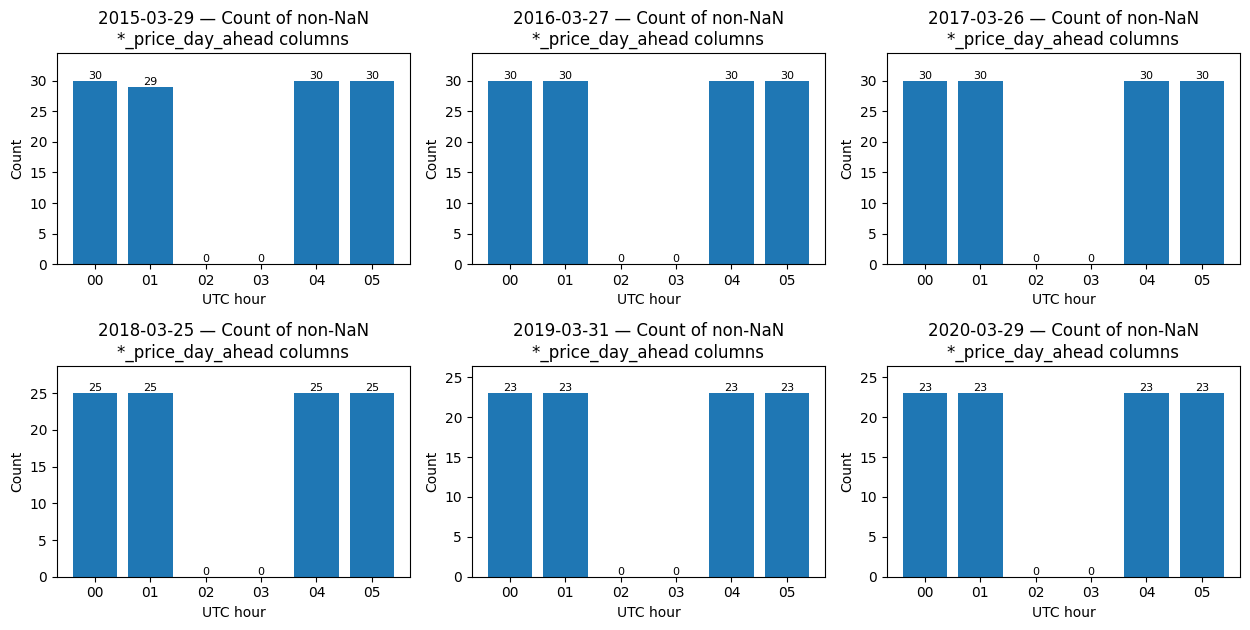

In [24]:
# Normalize values to integers; treat "missing row" as 0 for plotting
hours = ["00","01","02","03","04","05"]
years = list(presence.keys())

n = len(years)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.2), squeeze=False)

for i, year in enumerate(years):
    ax = axes[i // cols][i % cols]
    row = presence[year]
    vals = []
    for h in hours:
        v = row.get(h, 0)
        if isinstance(v, str):  # e.g., "missing row"
            v = 0
        vals.append(int(v))
    ax.bar(hours, vals)
    ax.set_title(f"{year} — Count of non-NaN\n*_price_day_ahead columns")
    ax.set_ylim(0, max(vals + [1]) * 1.15)
    ax.set_xlabel("UTC hour")
    ax.set_ylabel("Count")
    for (x, y) in zip(hours, vals):
        ax.text(x, y, str(y), ha="center", va="bottom", fontsize=8)

# Hide any unused subplots
for j in range(i+1, rows*cols):
    axes[j // cols][j % cols].axis("off")

fig.tight_layout()
plt.show()


<h4> Summary of DST Jumps Analysis  </h4>

Having a consistent culprit, the `*_price_day_ahaed` columns, offers a partial explanation for the spikes: 

- Day-ahead prices are defined for **local delivery hours**.  
  On the spring DST change (02:00→03:00 local), one hour does not exist,  
  so the delivery day has **23 hours** and no price for one hour.

But: In the dataset, **two UTC timestamps** (`02:00` and `03:00 UTC`) are missing instead of one. Possible 
explanations:

  -  Inconsistent start- vs. end-of-hour labeling for the `*_price_day_ahaed` data - so both end points  
     of the missing hours got cancelled at one point.  
  -  Wrong time zone assignment  (local time has mistakenly been interpreted as `UTC`) plus, possibly, a later  remerging doubled the gap.    
  
The suspicion of a wrong time-zone assignment upstream stems from the initial observation: A consistent **offset**, `02:00` and `03:00 UTC` instead of `00:00` and `01:00 UTC`.   Such a  **double conversion / timezone mix-up** could explain both  the apparent one-hour delay and the two-timestamp gap.


<h3> Missingness at the Data Set's Boundaries </h3>

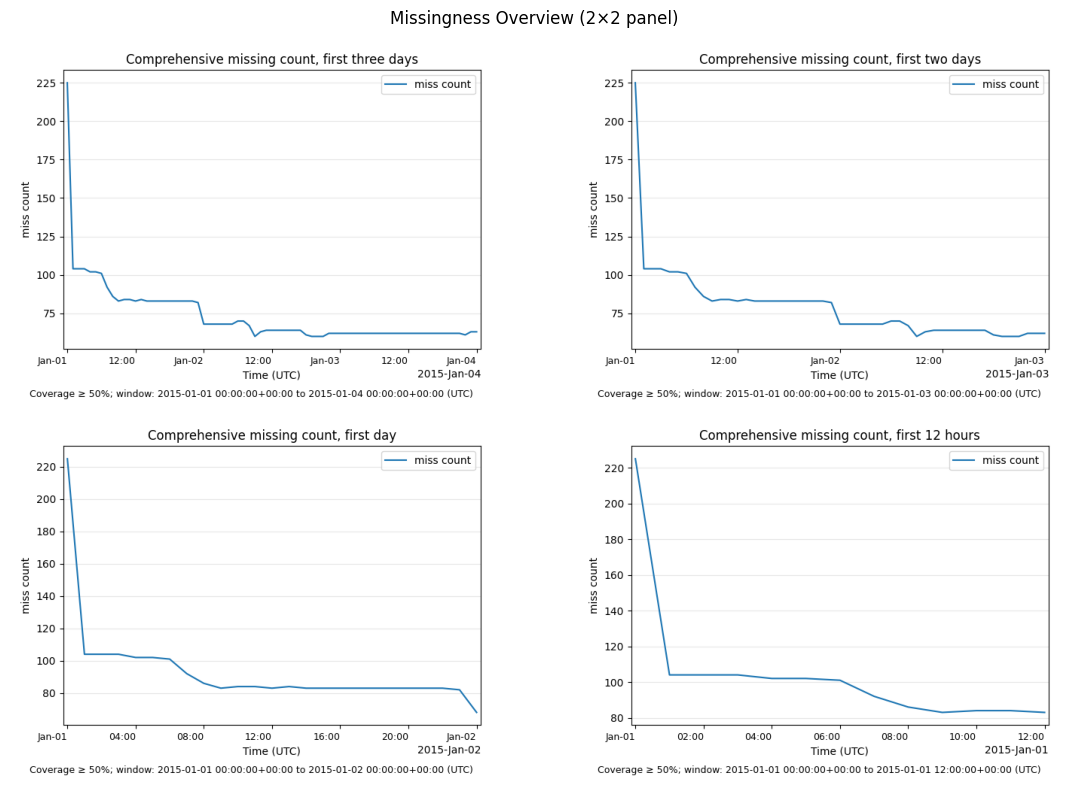

In [25]:
fig1, ax1 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2015-01-04 00:00:00",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive missing count, first three days",
)

fig2, ax2 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2015-01-03 00:00:00",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive missing count, first two days",
)

fig3, ax3 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2015-01-02 00:00:00",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive missing count, first day",
)

fig4, ax4 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2015-01-01 12:00:00",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive missing count, first 12 hours",
)

# Convert each figure to an image
imgs = [plotting_utils.fig_to_rgb_array(f) for f in (fig1, fig2, fig3, fig4)]

# Compose into a 2×2 panel
panel_fig, axes = plt.subplots(2, 2, figsize=(12, 8), squeeze=False)
for i, img in enumerate(imgs):
    ax = axes[i // 2][i % 2]
    ax.imshow(img)
    ax.axis("off")

panel_fig.suptitle("Missingness Overview (2×2 panel)", y=0.98, fontsize=12)
panel_fig.tight_layout()

# (Optional) Close the originals to free memory
plt.close(fig1); plt.close(fig2); plt.close(fig3); plt.close(fig4)

plt.show()

<h3> Missingness by Column Type </h3>

 Motivated by the results of the previous section, we now want to examine data completeness broken down by column type.

<h4> <code>price_day_ahead</code></h4>

The first such type, of course, are the `price_day_ahead` columns. For them,  `opsd_60min_columnwise_missingness_df` yields: 

In [26]:
df = opsd_60min_columnwise_missingness_df
mask = df["column"].astype("string", copy=False).str.contains("price_day_ahead", na=False, regex=False)
df.loc[mask].copy()

,column,n_missing,frac_missing
10,IE_sem_price_day_ahead,32886,0.652487
13,DE_LU_price_day_ahead,32861,0.651991
20,IT_GR_price_day_ahead,24874,0.493522
21,IT_NORD_CH_price_day_ahead,24874,0.493522
22,IT_NORD_AT_price_day_ahead,24825,0.492550
23,IT_NORD_FR_price_day_ahead,24825,0.492550
24,IT_NORD_SI_price_day_ahead,24825,0.492550
26,AT_price_day_ahead,17556,0.348326
29,IT_FOGN_price_day_ahead,15467,0.306879
30,IT_BRNN_price_day_ahead,15443,0.306403


We already knew, each `price_day_ahead` column has at least $12$ missing values. Here, we observe a missingness interval $[5, 32886]$. Next, we split the `price_day_ahead` columns from `OPSD_60min_df` and conduct a row-based analysis for each part.

In [27]:
# Split OPSD_60min_df into:
# - OPSD_60min_price_ahead_only_df  (price_ahead cols + timestamps)
# - OPSD_60min_no_price_ahead_df    (all remaining cols)

time_cols = ["utc_timestamp", "cet_cest_timestamp"]

# mask for price_ahead columns
col_mask   = pd.Index(OPSD_60min_df.columns).astype(str).str.contains("price_day_ahead", regex=False)
price_cols = OPSD_60min_df.columns[col_mask]

# keep timestamps if present
existing_time_cols = [c for c in time_cols if c in OPSD_60min_df.columns]

# final selection (timestamps first, then price cols), unique + ordered
sel_cols = list(dict.fromkeys(existing_time_cols + list(price_cols)))

OPSD_60min_price_ahead_only_df = OPSD_60min_df.loc[:, sel_cols].copy()
OPSD_60min_no_price_ahead_df   = OPSD_60min_df.drop(columns=price_cols).copy()
print(OPSD_60min_price_ahead_only_df.shape)
print(OPSD_60min_no_price_ahead_df.shape)


(50401, 34)
(50401, 268)


In [28]:
missingness_summary_price_ahead_only_df = eda_utils.count_missing_per_row(OPSD_60min_price_ahead_only_df)
missingness_summary_no_price_ahead_df = eda_utils.count_missing_per_row(OPSD_60min_no_price_ahead_df)

display(missingness_summary_price_ahead_only_df.head(10))
display(missingness_summary_price_ahead_only_df.info())

display(missingness_summary_no_price_ahead_df.head(10))
display(missingness_summary_no_price_ahead_df.info())


,utc_timestamp,cet_cest_timestamp,miss_count
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,32
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,31
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,20
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,20
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,20
5,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+01:00,20
6,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+01:00,20
7,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+01:00,20
8,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+01:00,20
9,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+01:00,20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   utc_timestamp       50401 non-null  datetime64[ns, UTC]          
 1   cet_cest_timestamp  50401 non-null  datetime64[ns, Europe/Berlin]
 2   miss_count          50401 non-null  int64                        
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), int64(1)
memory usage: 1.2 MB


None

,utc_timestamp,cet_cest_timestamp,miss_count
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,253
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,194
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,84
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,84
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,84
5,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+01:00,82
6,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+01:00,82
7,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+01:00,81
8,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+01:00,72
9,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+01:00,66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   utc_timestamp       50401 non-null  datetime64[ns, UTC]          
 1   cet_cest_timestamp  50401 non-null  datetime64[ns, Europe/Berlin]
 2   miss_count          50401 non-null  int64                        
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), int64(1)
memory usage: 1.2 MB


None

In [29]:
time_cols = ["utc_timestamp", "cet_cest_timestamp"]
left  = missingness_summary_price_ahead_only_df[[*time_cols, "miss_count"]].rename(columns={"miss_count": "miss_count_price_ahead_only"})
right =missingness_summary_no_price_ahead_df[[*time_cols, "miss_count"]].rename(columns={"miss_count": "miss_count_no_price_ahead"})
missingness_summaries_price_vs_no_price_df = pd.merge( left, right, on=time_cols, how="outer", validate="one_to_one", sort=True,)
missingness_summaries_price_vs_no_price_df = missingness_summaries_price_vs_no_price_df.sort_values(by="utc_timestamp").reset_index(drop=True)

We plot the overall missingness, the missingness of each subframe, and a dual comparison of the subframes’ missingness.


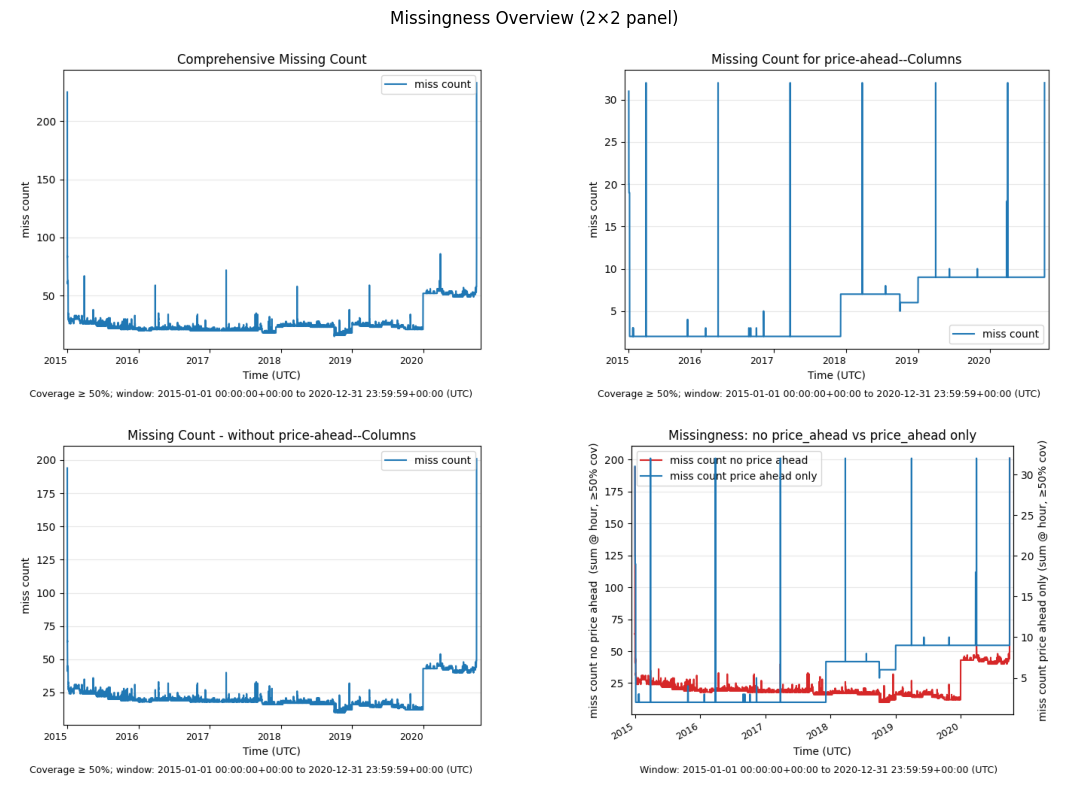

In [30]:
fig1, ax1 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive Missing Count",
)

fig2, ax2 = plotting_utils.plot_resampled(
    df=missingness_summary_price_ahead_only_df,
    start_date="2015-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count for price-ahead--Columns",
)

fig3, ax3 = plotting_utils.plot_resampled(
    df=missingness_summary_no_price_ahead_df,
    start_date="2015-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count - without price-ahead--Columns",
)

fig4, (ax4l, ax4r) = plotting_utils.plot_dual_resampled(
    df=missingness_summaries_price_vs_no_price_df,
    start_date="2015-01-01 00:00:00",
    end_date="2020-12-31 23:59:59",
    column_one="miss_count_no_price_ahead",
    column_two="miss_count_price_ahead_only",
    granularity_one="H",
    granularity_two="H",
    time_col="utc_timestamp",
    how_one="sum",
    how_two="sum",
    coverage_threshold_one=0.5,
    coverage_threshold_two=0.5,
    color_one="tab:red",
    color_two="tab:blue",
    title="Missingness: no price_ahead vs price_ahead only",
)

# Convert each figure to an image
imgs = [plotting_utils.fig_to_rgb_array(f) for f in (fig1, fig2, fig3, fig4)]

# Compose into a 2×2 panel
panel_fig, axes = plt.subplots(2, 2, figsize=(12, 8), squeeze=False)
for i, img in enumerate(imgs):
    ax = axes[i // 2][i % 2]
    ax.imshow(img)
    ax.axis("off")

panel_fig.suptitle("Missingness Overview (2×2 panel)", y=0.98, fontsize=12)
panel_fig.tight_layout()

# (Optional) Close the originals to free memory
plt.close(fig1); plt.close(fig2); plt.close(fig3); plt.close(fig4)

plt.show()


The shortening of the DST jump days' spikes by $32$ counts  is clearly visible, but there still seems to remain a certain spikiness. The year $2017$ sticks out.  

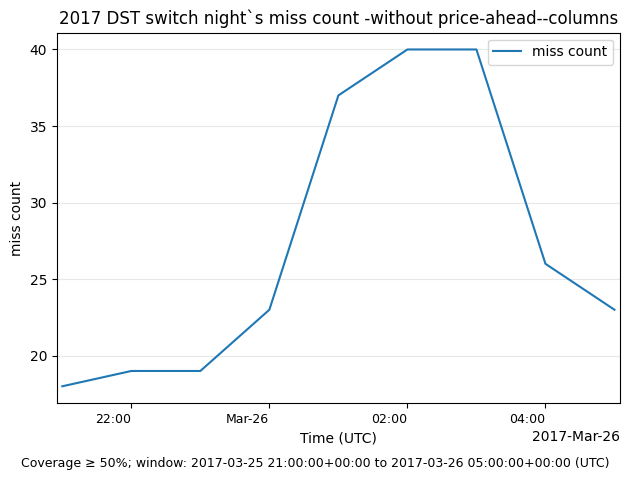

In [31]:
fig, ax = plotting_utils.plot_resampled(
      df=missingness_summary_no_price_ahead_df,
      start_date="2017-03-25 21:00",
          end_date="2017-03-26 05:00:00",
          column="miss_count",
          granularity="H",
          time_col="utc_timestamp",
          how="sum",
     coverage_threshold=0.5, 
     title="2017 DST switch night`s miss count -without price-ahead--columns")

Again, we see the local maximum attained at `02:00 UTC` and `03:00 UTC`. We take a look at the non-`price_day_ahead`-columns' missingness during all the DST switch nights.   

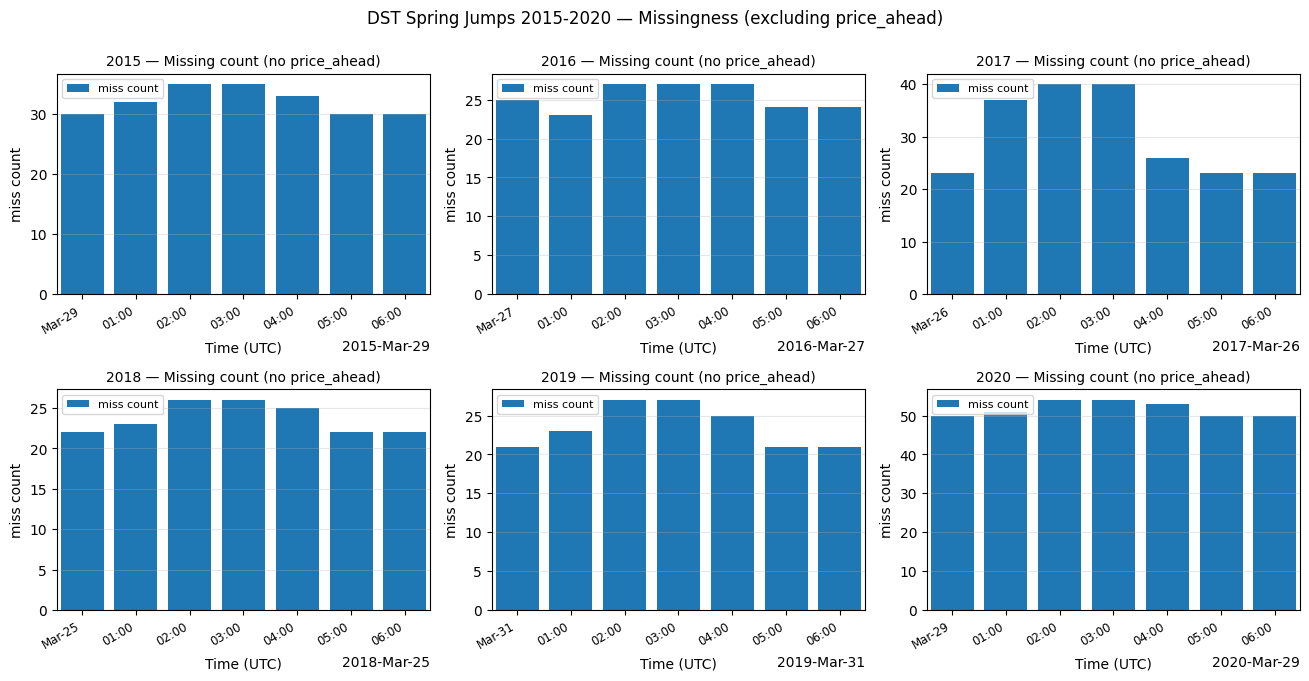

In [32]:
cols = 3
rows = math.ceil(len(jump_dates) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.4, rows*3.4), squeeze=False)

for i, d in enumerate(jump_dates):
    ax = axes[i // cols][i % cols]
    start_date = f"{d} 00:00:00"
    end_date   = f"{d} 06:00:00"  
    year = d[:4]

    plotting_utils.bar_plot_resampled(
        df=missingness_summary_no_price_ahead_df,
        start_date=start_date,
        end_date=end_date,
        column="miss_count",
        granularity="H",
        time_col="utc_timestamp",
        how="sum",
        coverage_threshold=0.5,
        color="tab:blue",
        title=f"{year} — Missing count (no price_ahead)",
        ax=ax,
    )

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    axes[j // cols][j % cols].axis("off")

fig.suptitle("DST Spring Jumps 2015-2020 — Missingness (excluding price_ahead)", y=0.995, fontsize=12)
fig.tight_layout()
plt.show()


The spikes are far less acute, but still the ever same observation: Maximum at `02:00` and `03:00 UTC`.

We take a look at the little follow-up spikes in april of 2016.

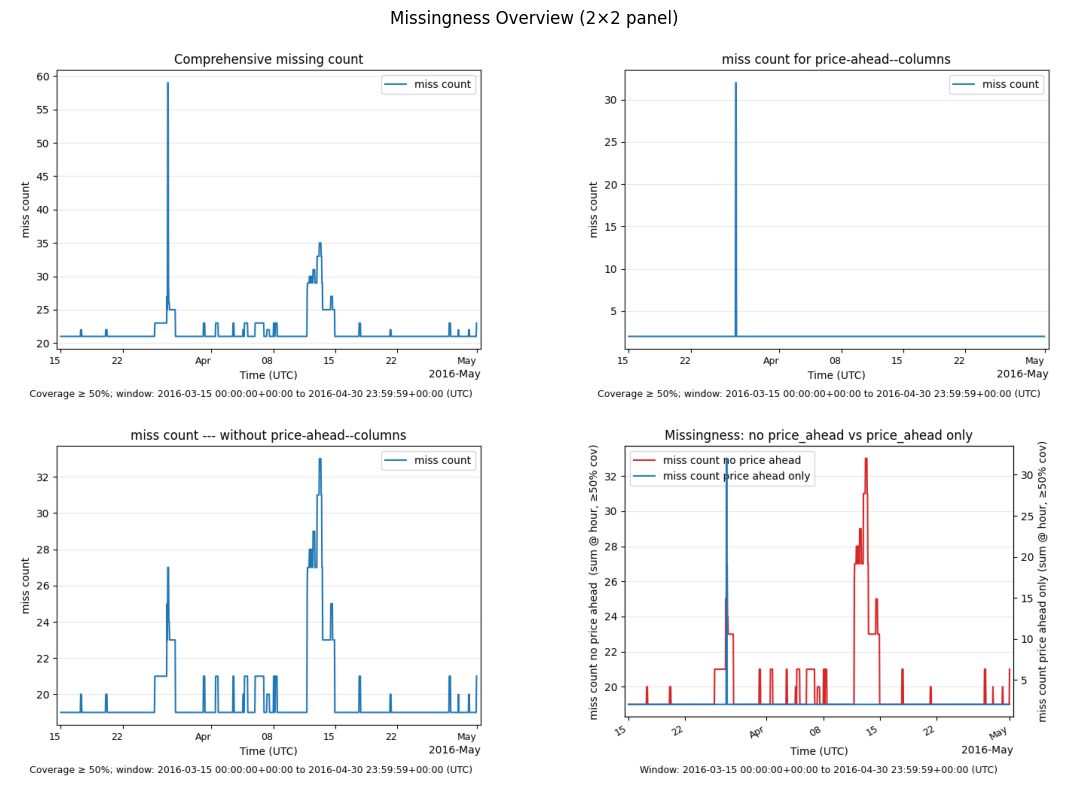

In [33]:

fig1, ax1 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2016-03-15 00:00",
    end_date="2016-04-30 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Comprehensive missing count",
)

fig2, ax2 = plotting_utils.plot_resampled(
    df=missingness_summary_price_ahead_only_df,
    start_date="2016-03-15 00:00",
    end_date="2016-04-30 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="miss count for price-ahead--columns",
)

fig3, ax3 = plotting_utils.plot_resampled(
    df=missingness_summary_no_price_ahead_df,
    start_date="2016-03-15 00:00",
    end_date="2016-04-30 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="miss count --- without price-ahead--columns",
)

fig4, (ax4l, ax4r) = plotting_utils.plot_dual_resampled(
    df=missingness_summaries_price_vs_no_price_df,
    start_date="2016-03-15 00:00",
    end_date="2016-04-30 23:59:59",
    column_one="miss_count_no_price_ahead",
    column_two="miss_count_price_ahead_only",
    granularity_one="H",
    granularity_two="H",
    time_col="utc_timestamp",
    how_one="sum",
    how_two="sum",
    coverage_threshold_one=0.5,
    coverage_threshold_two=0.5,
    color_one="tab:red",
    color_two="tab:blue",
    title="Missingness: no price_ahead vs price_ahead only",
)

# Compose four existing figures into a neat 2×2 panel (no changes to your plotting funcs)
# Convert each figure to an image
imgs = [plotting_utils.fig_to_rgb_array(f) for f in (fig1, fig2, fig3, fig4)]

# Compose into a 2×2 panel
panel_fig, axes = plt.subplots(2, 2, figsize=(12, 8), squeeze=False)
for i, img in enumerate(imgs):
    ax = axes[i // 2][i % 2]
    ax.imshow(img)
    ax.axis("off")

panel_fig.suptitle("Missingness Overview (2×2 panel)", y=0.98, fontsize=12)
panel_fig.tight_layout()

# (Optional) Close the originals to free memory
plt.close(fig1); plt.close(fig2); plt.close(fig3); plt.close(fig4)

plt.show()

<h2> Plot the Data </h2> 

First, we compare the average hourly load profiles across the days of the week. 

We use these masks for filtering. 


In [34]:
mon_mask = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(0,))  # Mon
tue_mask = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(1,))  # Tue
wed_mask = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(2,))  # Wed
thu_mask = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(3,))  # Thu
fri_mask   = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(4,))    # Fri
sat_mask   = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(5,))    # Sat
sun_mask   = fga.make_weekday_mask(OPSD_60min_df, "cet_cest_timestamp", weekdays=(6,))    # Sun

For the years 2015 to 2019, we aggregate the German grid load by weekday to obtain separate profiles for Monday through Sunday.

In [35]:
mon_prof, mon_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=mon_mask, drop_dst_switch_dates=True, return_counts=True
)
tue_prof, tue_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=tue_mask, drop_dst_switch_dates=True, return_counts=True
)
wed_prof, wed_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=wed_mask, drop_dst_switch_dates=True, return_counts=True
)
thu_prof, thu_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=thu_mask, drop_dst_switch_dates=True, return_counts=True
)
fri_prof, fri_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=fri_mask, drop_dst_switch_dates=True, return_counts=True
)
sat_prof, sat_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=sat_mask, drop_dst_switch_dates=True, return_counts=True
)
sun_prof, sun_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=sun_mask, drop_dst_switch_dates=True, return_counts=True
)

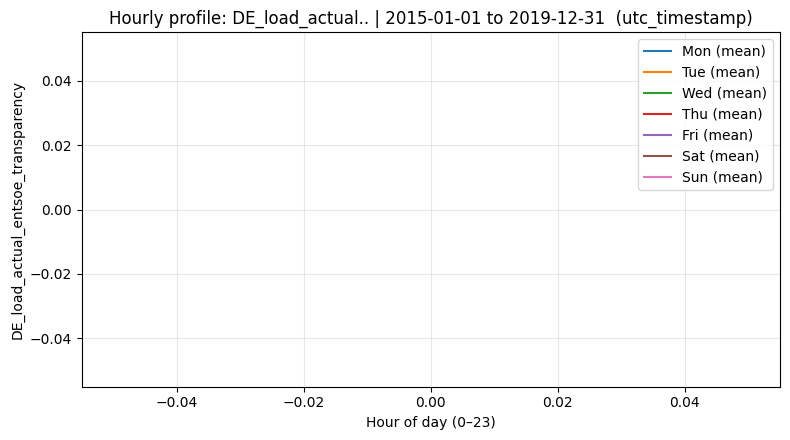

In [36]:
# Plot (matplotlib, one figure, default styles; hours are 0..23)
plt.figure(figsize=(8, 4.5))
plt.plot(mon_prof["hour"], mon_prof["value"], label="Mon (mean)")
plt.plot(tue_prof["hour"], tue_prof["value"], label="Tue (mean)")
plt.plot(wed_prof["hour"], wed_prof["value"], label="Wed (mean)")
plt.plot(thu_prof["hour"], thu_prof["value"], label="Thu (mean)")
plt.plot(fri_prof["hour"], fri_prof["value"], label="Fri (mean)")
plt.plot(sat_prof["hour"], sat_prof["value"], label="Sat (mean)")
plt.plot(sun_prof["hour"], sun_prof["value"], label="Sun (mean)")

plt.xlabel("Hour of day (0–23)")
plt.ylabel("DE_load_actual_entsoe_transparency")
plt.title(f"Hourly profile: {"DE_load_actual.."} | 2015-01-01 to 2019-12-31  ({ts_col})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


We observe a clear difference between the load profiles of workdays and those of Saturdays and Sundays. Among the workdays, the boundary days — Monday and Friday — stand out: the former begins with a lower load level in the early morning and remains the lowest workday profile until midday, while the latter shows a more rapid decline in the afternoon. Somewhat surprisingly, the average Saturday curve lies above the Monday curve during the first few hours of the day, and drops below the Sunday curve in the final hours.  
All curves display two local maxima — the primary (global) peak occurring around midday, and a secondary peak between five and six o’clock. When comparing the workdays, we find 

   Wednesday > Tuesday  > Thursday > Friday  > Monday  

at the global midday maximum with Friday and Monday switching places shortly after.  Our conclusion is therefore, that week-ends seem to have a moderating effect on closer weekdays, or, conversely: The further from the weekend, the higher the load.





We compare to the Covid year 2020 data:


In [37]:
covid_mon_prof, covid_mon_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=mon_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_tue_prof, covid_tue_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=tue_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_wed_prof, covid_wed_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=wed_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_thu_prof, covid_thu_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=thu_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_fri_prof, covid_fri_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=fri_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_sat_prof, covid_sat_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=sat_mask, drop_dst_switch_dates=True, return_counts=True
)
covid_sun_prof, covid_sun_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2020-01-01", "2020-08-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=sun_mask, drop_dst_switch_dates=True, return_counts=True
)

NameError: name 'value_col' is not defined

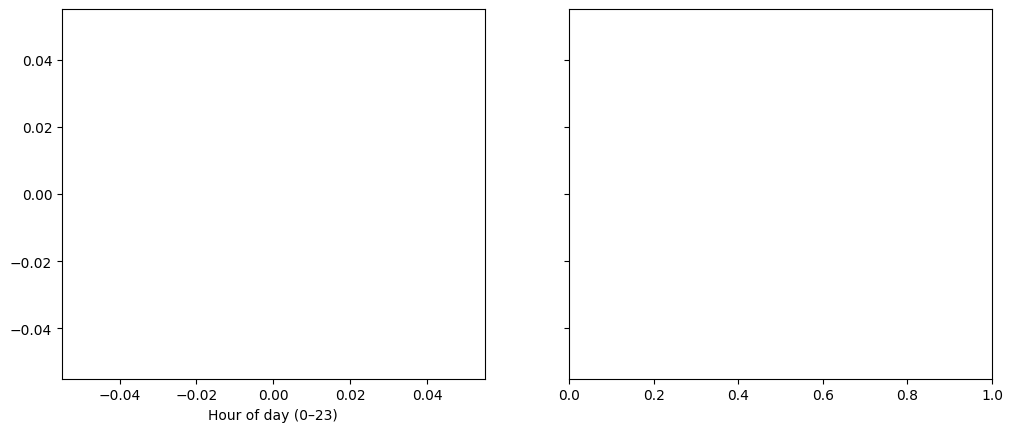

In [38]:
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)

# --- Left: 2015–2019 ---
axL.plot(mon_prof["hour"], mon_prof["value"], label="Mon (mean)")
axL.plot(tue_prof["hour"], tue_prof["value"], label="Tue (mean)")
axL.plot(wed_prof["hour"], wed_prof["value"], label="Wed (mean)")
axL.plot(thu_prof["hour"], thu_prof["value"], label="Thu (mean)")
axL.plot(fri_prof["hour"], fri_prof["value"], label="Fri (mean)")
axL.plot(sat_prof["hour"], sat_prof["value"], label="Sat (mean)")
axL.plot(sun_prof["hour"], sun_prof["value"], label="Sun (mean)")
axL.set_xlabel("Hour of day (0–23)")
axL.set_ylabel(value_col)
axL.set_title(f"2015–2019")
axL.grid(True, alpha=0.3)
axL.legend(ncols=2, fontsize=8)

# --- Right: 2020 (COVID year) ---
axR.plot(covid_mon_prof["hour"], covid_mon_prof["value"], label="Mon (mean)")
axR.plot(covid_tue_prof["hour"], covid_tue_prof["value"], label="Tue (mean)")
axR.plot(covid_wed_prof["hour"], covid_wed_prof["value"], label="Wed (mean)")
axR.plot(covid_thu_prof["hour"], covid_thu_prof["value"], label="Thu (mean)")
axR.plot(covid_fri_prof["hour"], covid_fri_prof["value"], label="Fri (mean)")
axR.plot(covid_sat_prof["hour"], covid_sat_prof["value"], label="Sat (mean)")
axR.plot(covid_sun_prof["hour"], covid_sun_prof["value"], label="Sun (mean)")
axR.set_xlabel("Hour of day (0–23)")
axR.set_title(f"2020 (Covid year)")
axR.grid(True, alpha=0.3)
axR.legend(ncols=2, fontsize=8)

fig.suptitle(f"Hourly Load Profile: 2015–2019 vs 2020 — DE_load_actual_entsoe_transparency", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


At this point, it is unclear whether the observed differences are due to COVID-19 effects or simply to the fact that data for the year 2020 cover only the first eight months. A comparison with the 2015–2019 data restricted to the same months should help clarify this.

In [ ]:
until_august_mask = OPSD_60min_df["cet_cest_timestamp"].dt.month.isin(range(1, 9))  # months 1..8 inclusive

In [ ]:
until_august_mon_prof, until_august_mon_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(mon_mask) & (until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_tue_prof, until_august_tue_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(tue_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_wed_prof, until_august_wed_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(wed_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_thu_prof, until_august_thu_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(thu_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_fri_prof, until_august_fri_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(fri_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_sat_prof, until_august_sat_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="cet_cest_timestamp", agg="mean",
    mask=(sat_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)
until_august_sun_prof, until_august_sun_meta = fga.aggregate_hourly_profile(
    OPSD_60min_df, "DE_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="cet_cest_timestamp", agg="mean",
    mask=(sun_mask)&(until_august_mask), drop_dst_switch_dates=True, return_counts=True
)


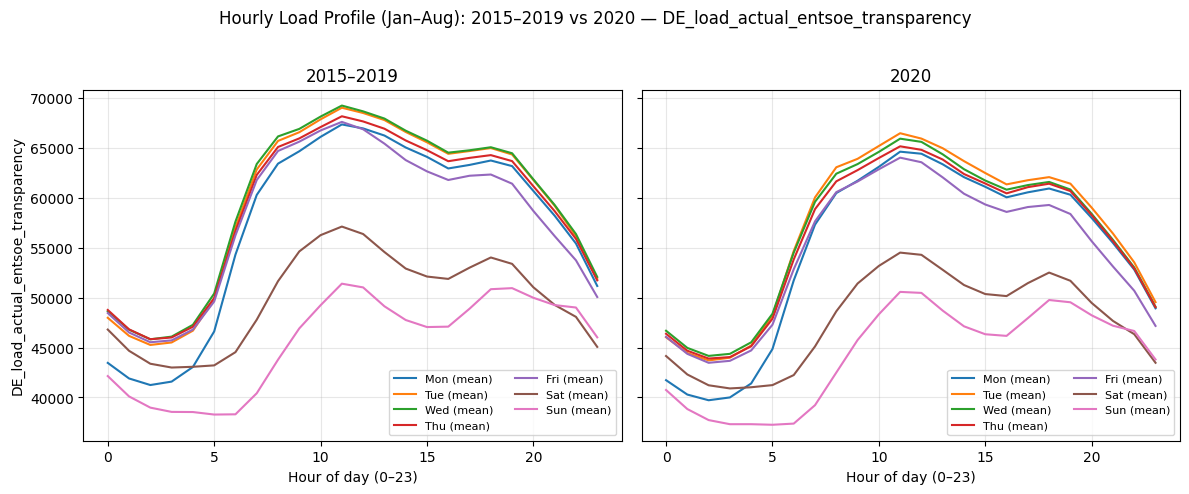

In [ ]:
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)

# --- Left: 2015–2019 ---
axL.plot(until_august_mon_prof["hour"], until_august_mon_prof["value"], label="Mon (mean)")
axL.plot(until_august_tue_prof["hour"], until_august_tue_prof["value"], label="Tue (mean)")
axL.plot(until_august_wed_prof["hour"], until_august_wed_prof["value"], label="Wed (mean)")
axL.plot(until_august_thu_prof["hour"], until_august_thu_prof["value"], label="Thu (mean)")
axL.plot(until_august_fri_prof["hour"], until_august_fri_prof["value"], label="Fri (mean)")
axL.plot(until_august_sat_prof["hour"], until_august_sat_prof["value"], label="Sat (mean)")
axL.plot(until_august_sun_prof["hour"], until_august_sun_prof["value"], label="Sun (mean)")
axL.set_xlabel("Hour of day (0–23)")
axL.set_ylabel(value_col)
axL.set_title(f"2015–2019")
axL.grid(True, alpha=0.3)
axL.legend(ncols=2, fontsize=8)

# --- Right: 2020 (COVID year) ---
axR.plot(covid_mon_prof["hour"], covid_mon_prof["value"], label="Mon (mean)")
axR.plot(covid_tue_prof["hour"], covid_tue_prof["value"], label="Tue (mean)")
axR.plot(covid_wed_prof["hour"], covid_wed_prof["value"], label="Wed (mean)")
axR.plot(covid_thu_prof["hour"], covid_thu_prof["value"], label="Thu (mean)")
axR.plot(covid_fri_prof["hour"], covid_fri_prof["value"], label="Fri (mean)")
axR.plot(covid_sat_prof["hour"], covid_sat_prof["value"], label="Sat (mean)")
axR.plot(covid_sun_prof["hour"], covid_sun_prof["value"], label="Sun (mean)")
axR.set_xlabel("Hour of day (0–23)")
axR.set_title(f"2020")
axR.grid(True, alpha=0.3)
axR.legend(ncols=2, fontsize=8)

fig.suptitle(f"Hourly Load Profile (Jan–Aug): 2015–2019 vs 2020 — DE_load_actual_entsoe_transparency", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


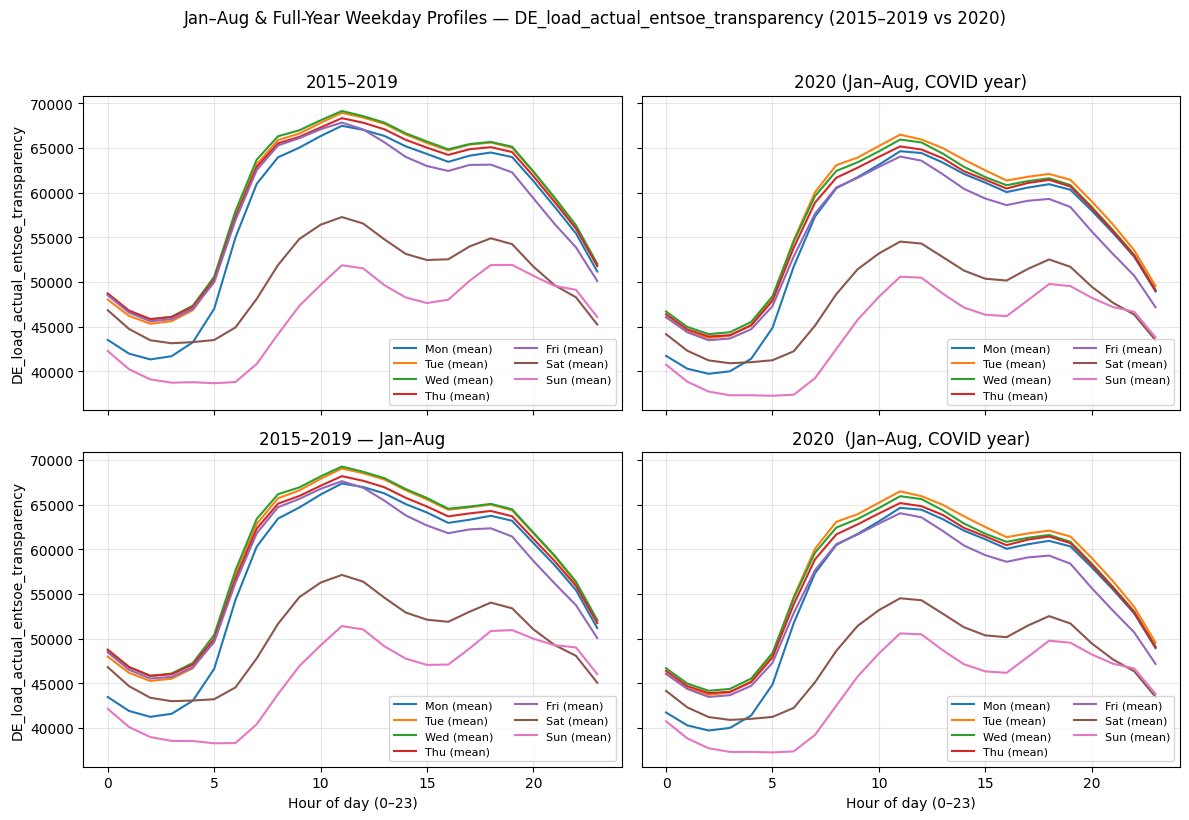

In [ ]:
def _plot_weekday_set(ax, profiles, title, ylabel=None, xlabel=False):
    # profiles: list of (label, df_with_columns_hour_value)
    for label, prof in profiles:
        ax.plot(prof["hour"], prof["value"], label=label)
    if xlabel:
        ax.set_xlabel("Hour of day (0–23)")
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(ncols=2, fontsize=8)
# --- Assemble profile lists ---
profiles_1519 = [
    ("Mon (mean)", mon_prof),
    ("Tue (mean)", tue_prof),
    ("Wed (mean)", wed_prof),
    ("Thu (mean)", thu_prof),
    ("Fri (mean)", fri_prof),
    ("Sat (mean)", sat_prof),
    ("Sun (mean)", sun_prof),
]

profiles_2020 = [
    ("Mon (mean)", covid_mon_prof),
    ("Tue (mean)", covid_tue_prof),
    ("Wed (mean)", covid_wed_prof),
    ("Thu (mean)", covid_thu_prof),
    ("Fri (mean)", covid_fri_prof),
    ("Sat (mean)", covid_sat_prof),
    ("Sun (mean)", covid_sun_prof),
]

profiles_1519_janaug = [
    ("Mon (mean)", until_august_mon_prof),
    ("Tue (mean)", until_august_tue_prof),
    ("Wed (mean)", until_august_wed_prof),
    ("Thu (mean)", until_august_thu_prof),
    ("Fri (mean)", until_august_fri_prof),
    ("Sat (mean)", until_august_sat_prof),
    ("Sun (mean)", until_august_sun_prof),
]

# Bottom-right intentionally reuses the COVID set
profiles_2020_janaug = profiles_2020
# --- Create 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
(ax11, ax12), (ax21, ax22) = axes
# Top row
(_plot_weekday_set(ax11, profiles_1519, "2015–2019", ylabel=value_col, xlabel=False))
(_plot_weekday_set(ax12, profiles_2020, "2020 (Jan–Aug, COVID year)", ylabel=None, xlabel=False))
# Bottom row
(_plot_weekday_set(ax21, profiles_1519_janaug, "2015–2019 — Jan–Aug", ylabel=value_col, xlabel=True))
(_plot_weekday_set(ax22, profiles_2020_janaug, "2020  (Jan–Aug, COVID year)", ylabel=None, xlabel=True))

fig.suptitle(
    "Jan–Aug & Full-Year Weekday Profiles — DE_load_actual_entsoe_transparency (2015–2019 vs 2020)",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()


<h2>Select Columns Relevant for Germany into Derived DataFrames</h2>

🇩🇪 We select the Germany-related columns and the two timestamp columns into a sub-frame: 

In [ ]:
germany_cols = [col for col in OPSD_60min_df.columns if col.startswith("DE_") or "timestamp" in col]
OPSD_60min_DE_df = OPSD_60min_df[germany_cols].copy()

In [ ]:
OPSD_60min_DE_df.head(4)

,utc_timestamp,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,...,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,...,13841.0,13362.0,NaN,3866.0,469.0,3398.0,5307.0,4703.0,NaN,5.0
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,...,13267.0,12858.0,NaN,3974.0,466.0,3508.0,5087.0,4562.0,NaN,7.0
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,...,12702.0,12611.0,NaN,4194.0,470.0,3724.0,4906.0,4517.0,NaN,8.0


🇩🇪 $+$ 🇱🇺 Since Luxembourg and Germany form one bidding zone, it might be beneficial to include the (two) Luxembourg columns as well.

In [ ]:
germany_lux_cols = [col for col in OPSD_60min_df.columns if col.startswith("DE_") or col.startswith("LU_") or  "timestamp" in col]
OPSD_60min_DE_LU_df = OPSD_60min_df[germany_lux_cols].copy()

We have $45$ columns now. 

In [ ]:
OPSD_60min_DE_LU_df.shape

(50401, 45)

In [ ]:
OPSD_60min_DE_LU_df.columns

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_50hertz_load_actual_entsoe_transparency',
       'DE_50hertz_load_forecast_entsoe_transparency',
       'DE_50hertz_solar_generation_actual',
       'DE_50hertz_wind_generation_actual',
       'DE_50hertz_wind_offshore_generation_actual',
       'DE_50hertz_wind_onshore_generation_actual',
       'DE_LU_load_actual_entsoe_transparency',
       'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead',
       'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual',
    

Here is a view of the columns grouped by prefixes.  

`50hertz`,`amprion` ,`tennet` and `transnetbw` refer to the  transmission system operators (TOS) currently operating in Germany.  Only the last one, `transnetbw`, has a control area that matches one federal state:  **Baden-Württemberg**.  The control area of `50hertz` contains the former **GDR**'s territory, the whole of  the city state **Berlin** and, in addition, the city state of **Hamburg**.  The control areas of `amprion` and `tennet` do not align well with the federal subdivision.  

| **Group**          | **Columns** |
|---------------------|-------------|
| **DE_LU** | `DE_LU_load_actual_entsoe_transparency`, `DE_LU_load_forecast_entsoe_transparency`, `DE_LU_price_day_ahead`, `DE_LU_solar_generation_actual`, `DE_LU_wind_generation_actual`, `DE_LU_wind_offshore_generation_actual`, `DE_LU_wind_onshore_generation_actual` |
| **DE** | `DE_load_actual_entsoe_transparency`, `DE_load_forecast_entsoe_transparency`, `DE_solar_capacity`, `DE_solar_generation_actual`, `DE_solar_profile`, `DE_wind_capacity`, `DE_wind_generation_actual`, `DE_wind_profile`, `DE_wind_offshore_capacity`, `DE_wind_offshore_generation_actual`, `DE_wind_offshore_profile`, `DE_wind_onshore_capacity`, `DE_wind_onshore_generation_actual`, `DE_wind_onshore_profile` |
| **LU** | `LU_load_actual_entsoe_transparency`, `LU_load_forecast_entsoe_transparency` |
| **DE_50hertz** | `DE_50hertz_load_actual_entsoe_transparency`, `DE_50hertz_load_forecast_entsoe_transparency`, `DE_50hertz_solar_generation_actual`, `DE_50hertz_wind_generation_actual`, `DE_50hertz_wind_offshore_generation_actual`, `DE_50hertz_wind_onshore_generation_actual` |
| **DE_amprion** | `DE_amprion_load_actual_entsoe_transparency`, `DE_amprion_load_forecast_entsoe_transparency`, `DE_amprion_solar_generation_actual`, `DE_amprion_wind_onshore_generation_actual` |
| **DE_tennet** | `DE_tennet_load_actual_entsoe_transparency`, `DE_tennet_load_forecast_entsoe_transparency`, `DE_tennet_solar_generation_actual`, `DE_tennet_wind_generation_actual`, `DE_tennet_wind_offshore_generation_actual`, `DE_tennet_wind_onshore_generation_actual` |
| **DE_transnetbw** | `DE_transnetbw_load_actual_entsoe_transparency`, `DE_transnetbw_load_forecast_entsoe_transparency`, `DE_transnetbw_solar_generation_actual`, `DE_transnetbw_wind_onshore_generation_actual` |


<h2> Data Completeness  Analysis for <code> OPSD_60min_DE_LU_df </code> </h2>

In [ ]:
OPSD_60min_DE_LU_columnwise_missingness_df = eda_utils.build_columnwise_missingness_report(OPSD_60min_DE_LU_df)
print(f"Columns analyzed: {len(OPSD_60min_DE_LU_columnwise_missingness_df)}")
display(OPSD_60min_DE_LU_columnwise_missingness_df)  

Columns analyzed: 45


,column,n_missing,frac_missing
0,DE_LU_load_forecast_entsoe_transparency,33745,0.669530
1,DE_LU_load_actual_entsoe_transparency,32877,0.652308
2,DE_LU_solar_generation_actual,32862,0.652011
3,DE_LU_price_day_ahead,32861,0.651991
4,DE_LU_wind_generation_actual,32855,0.651872
5,DE_LU_wind_offshore_generation_actual,32855,0.651872
6,DE_LU_wind_onshore_generation_actual,32855,0.651872
7,DE_solar_profile,6705,0.133033
8,DE_wind_profile,6676,0.132458
9,DE_wind_offshore_profile,6676,0.132458


Every `load_actual` columns has only one missing value. We take a closer look where they occur:

In [ ]:

load_actual_cols = [
    "DE_load_actual_entsoe_transparency",
    "DE_transnetbw_load_actual_entsoe_transparency",
    "DE_tennet_load_actual_entsoe_transparency",
    "DE_amprion_load_actual_entsoe_transparency",
    "DE_50hertz_load_actual_entsoe_transparency",
]
at_least_one_nan_mask = OPSD_60min_DE_LU_df[load_actual_cols].isna().any(axis=1)
OPSD_60min_DE_LU_actual_nan_df = OPSD_60min_DE_LU_df.loc[at_least_one_nan_mask]
display(OPSD_60min_DE_LU_actual_nan_df)

,utc_timestamp,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,...,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All German `load_actual` missing values occur in the very first row of the DataFrame, which is almost entirely composed of NaNs. This suggests that, although the dataset nominally starts at local midnight, actual data recording began only from UTC midnight on New Year’s Day. Alternatively, it may indicate a timezone inconsistency or a double conversion to `UTC`.

<h2> Export <code>OPSD_60min_DE_LU_df</code>  to Parquet  (<code>data/processed/</code>)</h2>

In [ ]:
from src.persist import save_parquet
p=save_parquet(OPSD_60min_DE_LU_df,   name="OPSD_60min_DE_LU_df", allow_overwrite = True)
print(f"OPSD_60min_DE_LU_df has been saved to {p}")

OPSD_60min_DE_LU_df has been saved to C:\Users\flosk\Documents\GitHub\electricity-demand-project\data\processed\OPSD_60min_DE_LU_df.parquet
